In [1]:
from glob import glob

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.units as munits

import datetime as dt, pytz
from dateutil import parser as du
from dateutil.tz import gettz

In [2]:
fps = 5
fpm = fps * 60

smoothing = 10 * 60

ifiles = sorted(glob("burnham/202009??_*_tr.csv"))

In [15]:
all_dets = []
all_people = []
for fn, f in enumerate(ifiles):

    file_ts = f.replace("burnham/", "").replace("_tr.csv", "").replace("_", " ")
    
    tzinfos = {"BRST": -7200, "CST": gettz("America/Chicago")}
    file_ts = du.parse(file_ts, tzinfos = tzinfos)
    file_unix = int(file_ts.timestamp())

    people = pd.read_csv(f)
    if not people.shape[0]: continue
        
    people["t"] /= fps
    people.sort_values(["o", "t"], inplace = True)
        
    people = people.groupby("o").agg(
                n    = pd.NamedAgg(column='o', aggfunc='count'),
                conf = pd.NamedAgg(column='conf', aggfunc='mean'),
                tmin = pd.NamedAgg(column='t', aggfunc='min'),
                tmax = pd.NamedAgg(column='t', aggfunc='max'),
                xmin = pd.NamedAgg(column='x', aggfunc='min'),
                xmax = pd.NamedAgg(column='x', aggfunc='max'),
                ymin = pd.NamedAgg(column='y', aggfunc='min'),
                ymax = pd.NamedAgg(column='y', aggfunc='max'),
                y0   = pd.NamedAgg(column='y', aggfunc='first'),
                yN   = pd.NamedAgg(column='y', aggfunc='last')
             )

    people["fn"] = fn
    people["fo"] = people.index
    
    people["dist"]  = np.sqrt((people.xmax - people.xmin)**2 + (people.ymax - people.ymin)**2)
    
    people["dy"] = people.yN - people.y0
    people["enter"] = people["dy"] < 0
    people["exit"]  = people["dy"] > 0

    people["duration"] = people["tmax"] - people["tmin"]
    
    people["unix"] = (file_unix + people.tmin).astype(int)
    people["ftmin"] = file_unix
    people["ftmax"] = int(file_unix + people.tmax.max())
    
    all_people.append(people.copy())

    people.query("enter & (n >= 10) & (dist >= 200)", inplace = True)
    
    people_n = people.groupby("tmin").count().n
    
    if int(people_n.index.max()) <= smoothing: continue
    
    det_per_min = pd.Series({t : people_n[(t <= people_n.index) & 
                                          (people_n.index < t + smoothing)].sum() * 60 / smoothing
                             for t in range(0, int(people_n.index.max() - smoothing), 60)},
                            name = "n").reset_index().rename(columns = {"index" : "t"})

    det_per_min["ts"] = file_ts + det_per_min.t.apply(lambda x: dt.timedelta(seconds = x))
    det_per_min["time"] = det_per_min.ts.dt.time
    det_per_min["doy"]  = det_per_min.ts.dt.dayofyear
    det_per_min["dow"]  = det_per_min.ts.dt.dayofweek
    det_per_min["down"] = det_per_min.ts.dt.day_name()
    det_per_min["unix"] = det_per_min.ts.astype(int)

    all_dets.append(det_per_min)
    
all_dets_merge = pd.concat(all_dets)
all_people_merge = pd.concat(all_people)

In [4]:
all_dets_merge["n"] = all_dets_merge["n"].round(3)
all_dets_merge[["unix", "n"]].to_csv("burnham/all_dets.csv", index = False)

all_people_merge = all_people_merge[["fn", "ftmin", "ftmax", "fo", "unix", "enter", 
                                     "dist", "duration", "conf", "n", "dy"]]

all_people_merge.to_csv("burnham/all_people.csv", index = False, float_format = "%.2f")

In [5]:
first_doy = all_dets_merge.doy.min()

all_dets_merge["ts_o"] = all_dets_merge.ts - \
                         all_dets_merge.doy.apply(lambda d : dt.timedelta(days = int(d - first_doy)))

all_dets_merge.set_index("ts_o", inplace = True)

for det in all_dets:
    
    det["ts_o"] = det.ts - det.doy.apply(lambda d : dt.timedelta(days = int(d - first_doy)))
    det.set_index("ts_o", inplace = True)


### Must shift all detections to 9/15

22
23
24
25
26
27
0
1
2
28
29
30
31
32
33
34
3
35
36
37
38
39
40
4
5
41
42
43
44
45
6
7
8
9
46
47
48
49
50
51
10
11
12
13
14
15
52
53
54
55
56
16
17
18
19
20
21
57
58
59
60


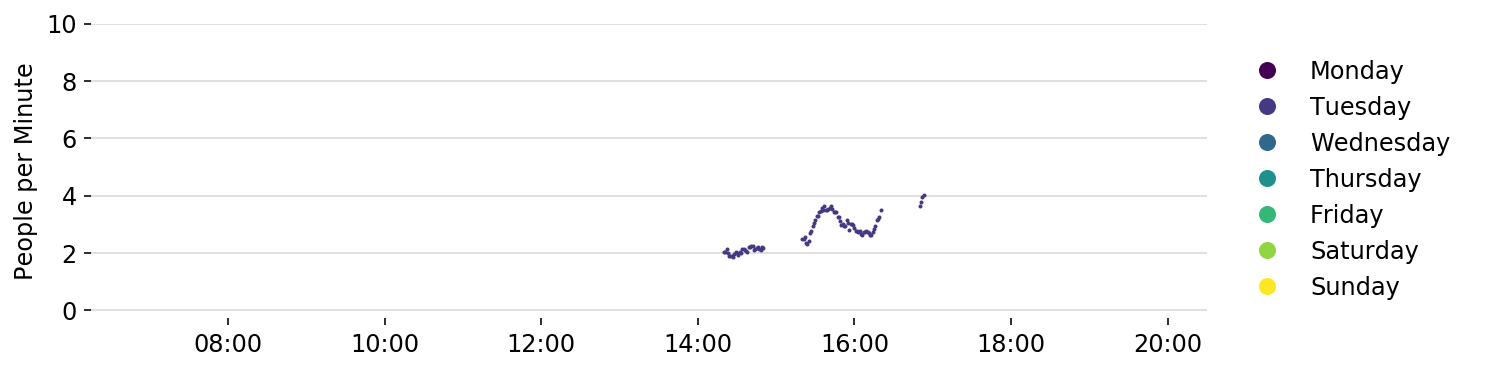

In [25]:
def date_format(ax):
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour = range(0, 24, 2)))
    ax.xaxis.set_tick_params(rotation = 0, pad = 4, labelsize = 12, which = "major")
    
    plt.xticks(rotation = 0, ha = 'center')
    
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    # ax.xaxis.set_minor_locator(mdates.HourLocator(byhour = range(1, 24, 2)))
    # ax.xaxis.set_tick_params(pad = 4, labelsize = 10, which = "minor")

vir  = plt.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin = 0, vmax = 6)
cmap = mpl.cm.ScalarMappable(cmap = vir, norm = norm)


fig, ax = plt.subplots(figsize = (10, 3))

labels = []
# for dow in [4]:
for dow in range(7): 
    for di, dets in enumerate(all_dets):
    
        color = [int(c*255) for c in cmap.to_rgba(dow)[:3]]
        color = "#{0:02X}{1:02X}{2:02X}FF".format(*color) 

        if dow not in set(dets.dow.unique()): continue

        down = dets.down.iloc[0]
        if down in labels: 
            label = ""
        else:
            label = down
            labels.append(down)
        
        dets.plot(x = "ts", y = "n", style = ".", color = color, ms = 2, ax = ax, label = label)
        
# plt.setp(ax.xaxis.get_majorticklabels(), rotation = 0)

ax.set_xlabel("")
ax.set_ylabel("People per Minute")

leg = ax.legend(loc = "upper left", bbox_to_anchor = (1, 1, 0, 0))

for handle in leg.legendHandles:
    handle._legmarker.set_markersize(15)

ax.grid(which = "major", axis = "y", color = "0.85")

ax.spines['left'].set_linewidth(0.0)
ax.spines['bottom'].set_linewidth(0.0)

date_format(ax)

ax.set_xlim(pd.Timestamp("2020-09-15 06:15:00"), pd.Timestamp("2020-09-15 20:30:00"))
ax.set_ylim(-0.25, 10)

ax.figure.savefig("figs/burnham_use.pdf", bbox_inches = "tight", pad_inches = 0.2)
ax.figure.savefig("figs/burnham_use.png", bbox_inches = "tight", pad_inches = 0.2,
                  facecolor = "w", edgecolor = "w")